<a href="https://colab.research.google.com/github/AlfaIV/RFinfSystem/blob/hm1_2/%D0%94%D0%971_2_%D0%A0%D0%A1%D0%9F%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дополнительное домашнее задание 1 по курсу РСПИ

* вариант: 16
* группа: РЛ1-93
* выполнил: Шаповалов Иван
* [github](https://github.com/AlfaIV/RFinfSystem/tree/hm1_2)
* [collab](https://colab.research.google.com/drive/1iqZ7XkYdhZiXfOxD7mM09mJUs2Te0vpB?usp=sharing)
* разрядность АЦП примем как и в ДЗ1, согласно рекомендации преподователя


### Условие:

1. Изобразите в draw.іо схему DPCM кодера, формирующего на выходе сигнал ошибки $e(n) = s(n) - \widehat{s}_q(n)$, поступающего на АЦП и затем передаваемого по каналу связи.

$$\widehat{s}_q(n) = \sum_{i=1} ^{p} a(i)s_q(n - i)$$

2. Изобразите в draw.іо схему DPCM декодера, формирующего на выходе востановленный сигнал из сигнала ошибки, принятого по каналу связи.
    
    * коэффициенты в кодере и декодере сигнала предполагаются заранее вычисленными и постоянными в течение некоторого интервала времени

1. Напишите следующие функции, реализующие операции кодирования/декодирования первичного сигнала источника информации:

    * функция расчета коэффициентов предсказания $a(i)$, предсказывающего значение сигнала по входящему сигналу ошибки.

    * функция DPCM-кодера, по схеме из п.1‚ принимающая на вход нормированный сигнал с нулевым математическим ожиданием и формирующим b—битный целочисленный сигнал ошибки на выходе (разрядность квантования необходимо получить у преподавателя индивидуально);

    * функция DPCM-декодера, по схеме из п.2, восстанавливающего исходный сигнал из сигнала ошибки.

1. Определите оптимальное значение порядка предсказывающего фильтра для сигнала из первой части домашнего задания по критерию максимума значения SQNR. Сравните результаты работы схемы компандирования и дифференциального кодирования.

Подключим требуемые библиотеки.

In [122]:
from math import sqrt, pi, exp, log, copysign, log10
from numpy import linspace, vectorize, random
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sg
import copy

Внесем требуемые константы.

In [123]:
b = 5
A = 87.56
1/A

0.011420740063956145

## Компоненты схемы из 1 ДЗ

Так как эти компоненты были приведены и рассмотрены ранее, ограничимся только кодовыми вставками.

### Формирование входного сигнала
Сформируем гауссовский СП с нулевым мат.  ожиданием и стандартным отклонением = 1, используя пакет Numpy.

In [124]:
mean = 0
std = 1
size = int(1e4)
gauss_sig = np.random.normal(mean, std, size)

Теперь на основе полученных выборок сигнала сформируем сигнал требуемого, в условии задания, вида

In [125]:
def s(n, gauss_sig):
  a_1, b_0, b_1 = 0.5, 1, 2 #параметры принимаем такими так как не заданно другое значение
  try:
    previous_val = b_0*gauss_sig[0] #храним предыдущее значение, избавляемся от рекурсии
    returned_sig = [] #возвращаемый массив данных
    for n_i in range(n)[1:]:
      returned_sig.append(previous_val)
      previous_val = a_1*previous_val + b_0*gauss_sig[n_i] + b_1*gauss_sig[n_i - 1]

    returned_sig.append(previous_val)
    return returned_sig
  except IndexError:
    print("Некорректный массив гауссовых значений")

In [126]:
n = np.arange(size)
sig = s(size, gauss_sig)

Так как в условии требуеться нормированный сигнал с нулевым мат. ожиданием. Нормируем полученный сигнал

In [127]:

sig_norm_ = (sig - np.mean(sig))/np.std(sig)
sig_norm = 2*(sig_norm_ - min(sig_norm_))/(max(sig_norm_) - min(sig_norm_)) - 1

Теперь мы имеем действительно нормированный сигнал

In [128]:
print("Для нормированного \"исходного\" сигнала:")
print("Среднее значение:", np.mean(sig_norm))
print("Медиана:", np.median(sig_norm))
print("Дисперсия:", np.var(sig_norm))
print("Стандартное отклонение:", np.std(sig_norm))
print("Минимальное значение:", np.min(sig_norm))
print("Максимальное значение:", np.max(sig_norm))
# print("===================")

Для нормированного "исходного" сигнала:
Среднее значение: 0.051396116143749546
Медиана: 0.05253511009660983
Дисперсия: 0.06412054917280274
Стандартное отклонение: 0.2532203569478622
Минимальное значение: -1.0
Максимальное значение: 1.0


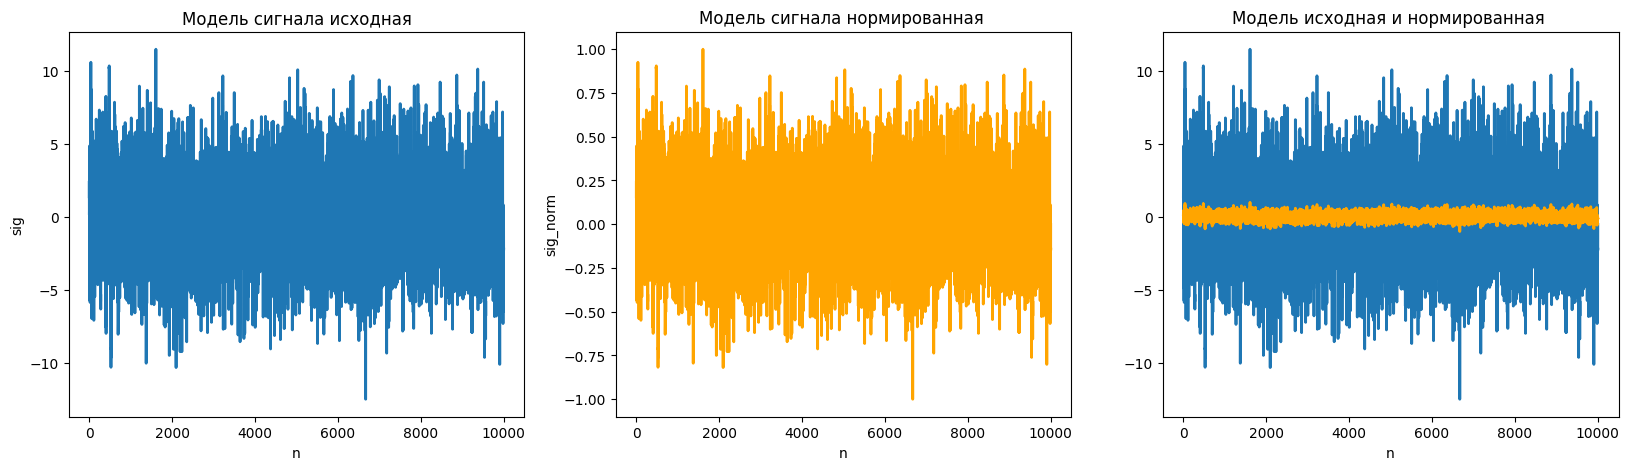

In [129]:
# %%capture
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3)


ax1.plot(n, sig, linewidth=2.0)
ax1.set_title('Модель сигнала исходная')
ax1.set_xlabel('n')
ax1.set_ylabel('sig')

ax2.plot(n, sig_norm, linewidth=2.0, color="orange")
ax2.set_title('Модель сигнала нормированная ')
ax2.set_xlabel('n')
ax2.set_ylabel('sig_norm')

ax3.plot(n, sig, linewidth=2.0)
ax3.plot(n, sig_norm, linewidth=2.0, color="orange")
ax3.set_title('Модель исходная и нормированная ')
ax3.set_xlabel('n')




fig.set_size_inches(20, 5)
plt.show()

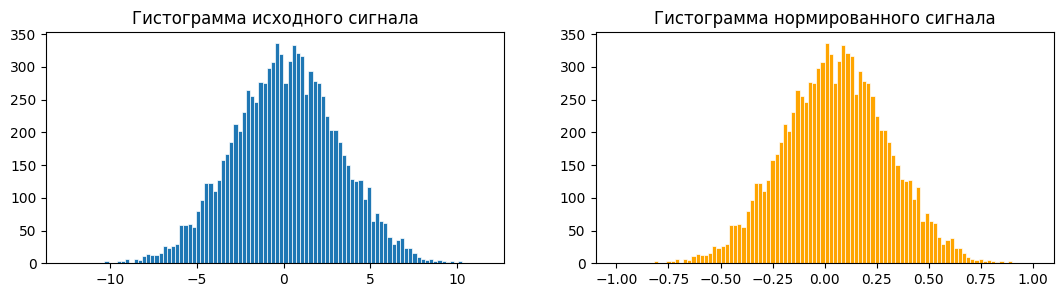

In [130]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(sig, bins=int(size/100), linewidth=0.5, edgecolor="white")
ax1.set_title('Гистограмма исходного сигнала')

ax2.hist(sig_norm, bins=int(size/100), linewidth=0.5, edgecolor="white", color="orange")
ax2.set_title('Гистограмма нормированного сигнала')

fig.set_size_inches(13, 3)
plt.show()

### Функция квантователя

In [131]:
def quantizer(signal, N):
  quantized_signal = []
  level_number = 2**N
  step = (max(signal) - min(signal))/level_number
  levels = np.array([step*i for i in range(level_number + 1)]) + min(signal)
  for countdown in signal:
    distance = np.abs(levels - countdown)
    curent_level = levels[np.argmin(distance)]
    quantized_signal.append(curent_level)
  return quantized_signal, levels


### Расчет SQNR

In [132]:
SQNR = lambda sig_norm, expand_sig: 10*log10(sum(sig_norm**2)/sum((sig_norm - expand_sig)**2))

# DPCM кодирование

Для проведения DPCM кодирования требуеться расчет __корреляционной функции__ сигнала:

$$r_{ss}(m) = \sum_{i=1} ^{N} {s(i)s(i + m)}$$

Приведем её инициализацию.

In [133]:
r_ss = lambda s,m: np.correlate(s[:len(s) - m],s[m:])

Также для DPCM кодера потребуються __расчет коэфициентов предсказания $a_i(n)$__:

$$\sum_{i = 1}^{p} a(i)r_{ss}(i - j) = r_{ss}(j), j = 1,2,...,p$$

или в матрицной форме

$$Ra = r \rightarrow R^{-1}r$$

где R - корреляционная матрица сигнала, a - вектор коэффицинтов предсказания, r - вектор коэффициентов корреляции

In [134]:
def get_A(s, p):
  R = np.empty((p, p))
  r = np.empty(p)
  for j in range(p):
    r[j] = r_ss(s, j)
    for i in range(p):
      # R[j][i] = r_ss(s, i - j)
      if i - j >= 0 and i - j < len(s):
        R[j][i] = r_ss(s, i - j)
  return np.dot(np.linalg.inv(R),r)

__Предсказывает текущий отсчет__ сигнала $s(n)$ DPCM кодер, на основе предыдущих p отсчетов, по следующей формуле:

$$\widehat{s}(n) = \sum_{i = 1}^{p} a(i)s(n - i)$$

Напишем соответсвующую функцию.

In [135]:
def sig_calculate(n, s, a, p):
  res = []
  for i in range(p):
    if n - i > 0:
      res.append(a[i]*s[n - i])
  type(sum(res))
  return sum(res)

DPCM кодер передает в каал связи разницу между отсечтами. На основе этой особенности напишем __кодер и декодер__.

In [136]:
code_sig = lambda s, a, p: [s[n] - sig_calculate(n, s, a, p) for n in range(len(s))]

In [137]:
encode_sig =  lambda differ, a, p: [differ[n] + sig_calculate(n, differ, a, p) for n in range(len(differ))]

Общая схема моделируемого канала связи выглядит следующим образом

![DPCM coder](https://github.com/AlfaIV/RFinfSystem/blob/hm1_2/png/DPCM.png?raw=true)

На основе это схемы и модулей, написанных ранее, создадим модель обработки сигнала(цепи обработки).

In [138]:
def DPCM_circuit(input_signal, p):
  A = get_A(input_signal ,p)
  code_data = code_sig(input_signal, A, p)
  quanted_data = quantizer(code_data ,b)[0]
  encode_data = encode_sig(quanted_data, A, p)
  return {"encode_data": encode_data,
          "quanted_data": quanted_data,
          "code_data": code_data,
          "A": A}

Проведем расчет параметров A например для сигнала из певого ДЗ со следующим  параметром p. И посмотрим как будет преобразовываться сигнал.

In [139]:
p = 3
DPCM_data = DPCM_circuit(sig_norm,p)

(100.0, 200.0)

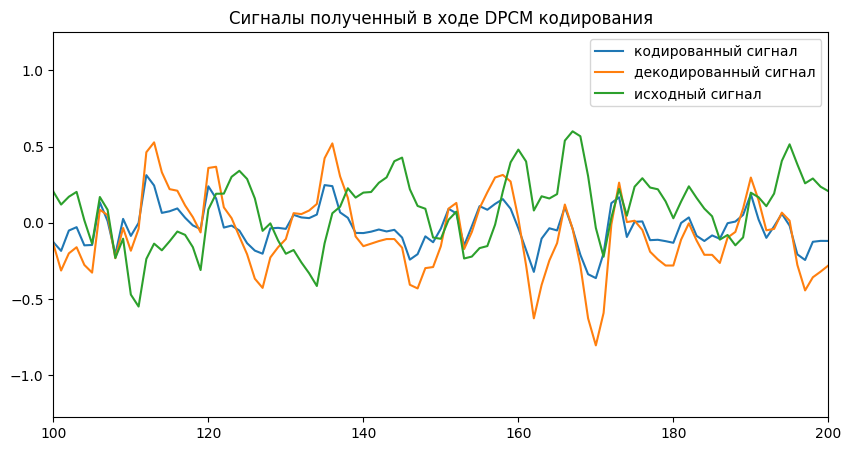

In [140]:
plt.figure(figsize=(10,5))
plt.plot(DPCM_data["code_data"], label="кодированный сигнал")
plt.plot(DPCM_data["encode_data"], label="декодированный сигнал")
plt.plot(sig_norm, label="исходный сигнал")
plt.title("Сигналы полученный в ходе DPCM кодирования")
plt.legend()
plt.xlim(100,200)

Таким образом, мы могли наблюдать, что применение DPCM кодера уменьшает динамический диапазон передаваемого сигнал, что в частности позволяет использовать АЦП с меньшей разрядности.
Также стоит отметить, искажение формы восстановленного сигнала относительно исходного.


А теперь перейдем к подбору оптимального значения p, по максимосу SQNR. Для удобства расчетов напишем отдельную функцию.

In [141]:
def GetSQNR(p_range, sig):
  DPCM_data = [DPCM_circuit(sig, p_i)["encode_data"] for p_i in p_range]
  SQNR_data = [SQNR(sig, DPCM_data_i) for DPCM_data_i in DPCM_data]
  return SQNR_data

Проведем расчеты значений SQNR в представленном ниже диапазоне параметров p.

In [142]:
p_range = np.arange(1,30,1)
SQNR_data = GetSQNR(p_range, sig_norm)
SQNR_max = max(SQNR_data)
p_max = p_range[np.argmax(SQNR_max)]

Text(33, -15, 'параметр Р: 1')

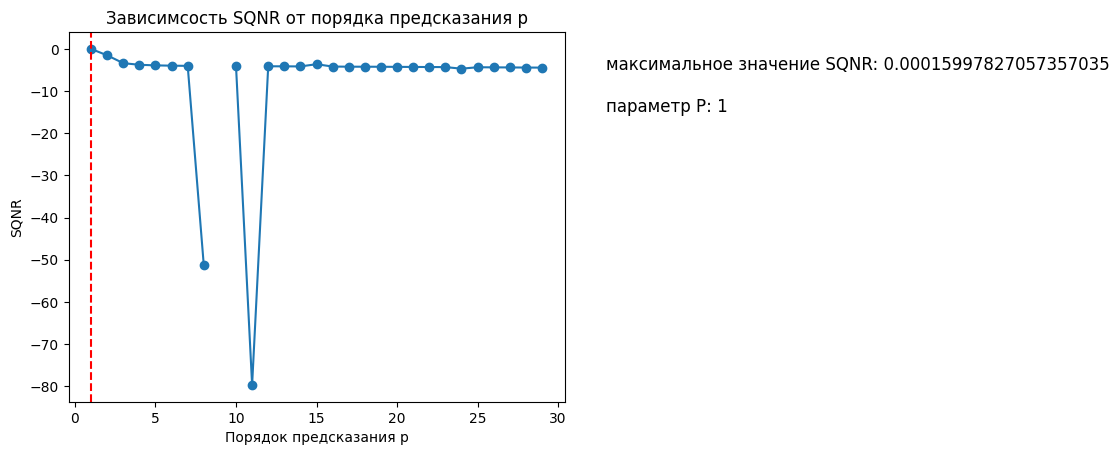

In [143]:
# plt.figure(figsize=(10,10))
plt.plot(p_range, SQNR_data, marker = "o")
plt.axvline(p_max, color = "red",linestyle = "dashed")
plt.title("Зависимсость SQNR от порядка предсказания p")
plt.xlabel("Порядок предсказания p")
plt.ylabel("SQNR")
plt.text(33, -5, f'максимальное значение SQNR: {SQNR_max}', fontsize=12, color='black')
plt.text(33, -15, f'параметр Р: {p_max}', fontsize=12, color='black')

Стоит обратить внимание на довольно странный график зависимости SQNR от парядка пресказания p.

Его форму можно обьяснить следующим образом, так как на входе падаеться сигнал имеющий Гауссовское распределение т.е. фактически случайные скачки напряжения. И какие-то попытки предсказать последующую выборку на основе любого количества предыдущих - в общем случае не имеют смысла.

Таким образом, применять DPCM кодирование для случайного ГСП не имеет смысла.